In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import csd
from data_preprocessing import preprocess
import seaborn as sns

df = preprocess()


In [ ]:
# Taken from CSD_matrix.py
def cross_spectral_matrix(patient_id, dataframe, wave_option='power_beta', surrogate=False):
    """Function mainly used for returns the CSD Matrices"""
    patient_data = dataframe[dataframe['id'] == patient_id]

    #Create an empty list to hold the power data for each region (channel)
    power_data = []

    sampling_freq = 128

    #Loops through the regions (channels) and extract power data
    for region in patient_data['region'].unique():

        #Filters power data for the current region
        region_data = patient_data[patient_data['region'] == region]
        
        #Append the power data (list) for this region to the list
        power_data.append(region_data[wave_option].values[0])  # Assuming 'power' is a list

    #Converts the list of power data (regions x time points) into a DataFrame
    power_df = pd.DataFrame(power_data).transpose()

    #Checks for missing values
    if power_df.isnull().values.any():
        print(f"Warning: Missing values detected in power data for patient {patient_id}")
        power_df = power_df.fillna(0)  # Fill NaN with 0

    channels = power_df.columns
    csd_matrix = np.zeros((len(channels), len(channels)), dtype=complex)

    #Computes CSD Matrix
    for i, ch1 in enumerate(channels):
        for j, ch2 in enumerate(channels):

            #Computes CSD between two channels
            freqs, csd_values = csd(power_df[ch1], power_df[ch2], fs=sampling_freq, nperseg=240)
            
            # Take the average value of the CSD (optional: could store full spectrum instead)
            csd_matrix[i, j] = np.mean(csd_values)

    #Normalizes CSD Matrix
    for i in range(len(channels)):
        for j in range(len(channels)):
            if i != j:
                csd_matrix[i, j] = csd_matrix[i, j] / np.sqrt(csd_matrix[i, i] * csd_matrix[j, j])
    
    np.fill_diagonal(csd_matrix, 1) #Explicitly sets the diagonals to 1
    
    #Returns the CSD matrix
    return csd_matrix, freqs
    
    
def average_csd(patient_ids, wave_option):
    "Function that computes average csd matrix"
    csd_sums = None
    count = 0

    # Loop through each patient and calculate their CSD matrix
    for patient_id in patient_ids:
        csd_matrix, _ = cross_spectral_matrix(patient_id, wave_option)  # Call your CSD function

    # Add the current CSD matrix to the cumulative sum
        if csd_sums is None:
            csd_sums = csd_matrix
        else:
            csd_sums += csd_matrix

        count += 1

    # Calculate the average CSD matrix
    average_csd_matrix = np.abs(csd_sums / count) #Manitude of the complex values

   # average_csd_df = pd.DataFrame(average_csd_matrix)

    return average_csd_matrix



In [4]:
healthy_patients = df[df['schizo'] == 0]['id'].unique().tolist()
schizo_patients = df[df['schizo'] == 1]['id'].unique().tolist()

In [ ]:
def bootstrap_samples(wave_option, samples, healthy_patients=healthy_patients, schizo_patients=schizo_patients):
    "Given a certain wave, samples the average csd matrixes."
    bootstrap_samples_healthy = [
        np.random.choice(healthy_patients, size=5, replace=True)
        for _ in range(samples)
    ]

    healthy_crossvals = [
        average_csd(sample, wave_option=wave_option)
        for sample in bootstrap_samples_healthy
    ]
    bootstrap_samples_schizo = [
        np.random.choice(schizo_patients, size=5, replace=True)
        for _ in range(samples)
    ]

    schizophrenic_crossvals = [
        average_csd(sample, wave_option=wave_option)
        for sample in bootstrap_samples_schizo
    ]
    return healthy_crossvals, schizophrenic_crossvals

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_p_value_matrix(wave, sample_size, n_iterations=10000):
    """
    Performs a two sided p value calculation with the null hypothesis being obtained
    by permutations. So that there is no difference. 
    """
    mapping = {
        "Ch1": "F7", "Ch2": "F3", "Ch3": "F4", "Ch4": "F8",
        "Ch5": "T3", "Ch6": "C3", "Ch7": "Cz", "Ch8": "C4",
        "Ch9": "T4", "Ch10": "T5", "Ch11": "P3", "Ch12": "Pz",
        "Ch13": "P4", "Ch14": "T6", "Ch15": "O1", "Ch16": "O2"
    }

    #Get labels and samples
    channel_label = list(mapping.values())
    healthy_crossvals, schizophrenic_crossvals = bootstrap_samples(wave, sample_size)

    num_channels = healthy_crossvals[0].shape[0]
    # Start with an empty matrix
    p_value_matrix = np.zeros((num_channels, num_channels))

    # Loop through channels 
    for ch1 in range(num_channels):
        for ch2 in range(ch1 + 1, num_channels):

            # So for each sample we extract the csd values
            cross_channel_healthy = [csd[ch1, ch2] for csd in healthy_crossvals]
            cross_channel_schizo = [csd[ch1, ch2] for csd in schizophrenic_crossvals]

            # Get the mean difference between them
            mean_diff_observed = np.mean(cross_channel_healthy) - np.mean(cross_channel_schizo)

            # Now create the null distribution by cocatenating
            combined = np.concatenate([cross_channel_healthy, cross_channel_schizo])
            null_diffs = []

            # Get the null difference by shuffling and seeing what the difference between first and second
            # half is
            for _ in range(n_iterations):
                shuffled = np.random.permutation(combined)
                sample1 = shuffled[:len(cross_channel_healthy)]
                sample2 = shuffled[len(cross_channel_healthy):]
                null_diffs.append(np.mean(sample1) - np.mean(sample2))

            # Two-sided p-value calculation
            null_diffs = np.array(null_diffs)
            p_value = np.mean((null_diffs >= mean_diff_observed) | (null_diffs <= -mean_diff_observed))

            # Make use of symmetry
            p_value_matrix[ch1, ch2] = p_value
            p_value_matrix[ch2, ch1] = p_value

    # Plot the p-value matrix as a heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(p_value_matrix, annot=True, fmt=".2f", cmap="coolwarm_r", cbar=True, xticklabels=channel_label, yticklabels=channel_label)
    plt.title("P-Value Matrix")
    plt.xlabel("Channel")
    plt.ylabel("Channel")
    plt.show()




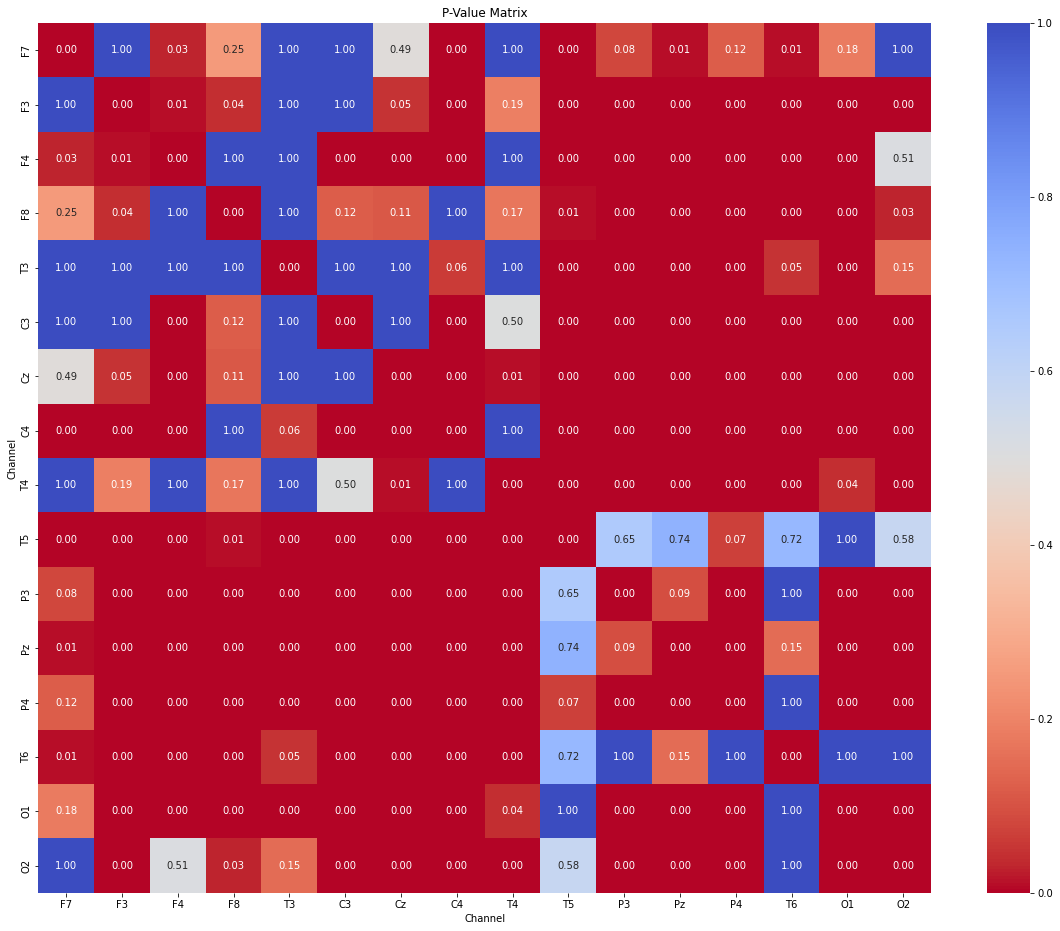

In [ ]:
# These values here are lower so that it runs faster, we used higher values in the actual presentation.
plot_p_value_matrix('power_beta', 50, 100)

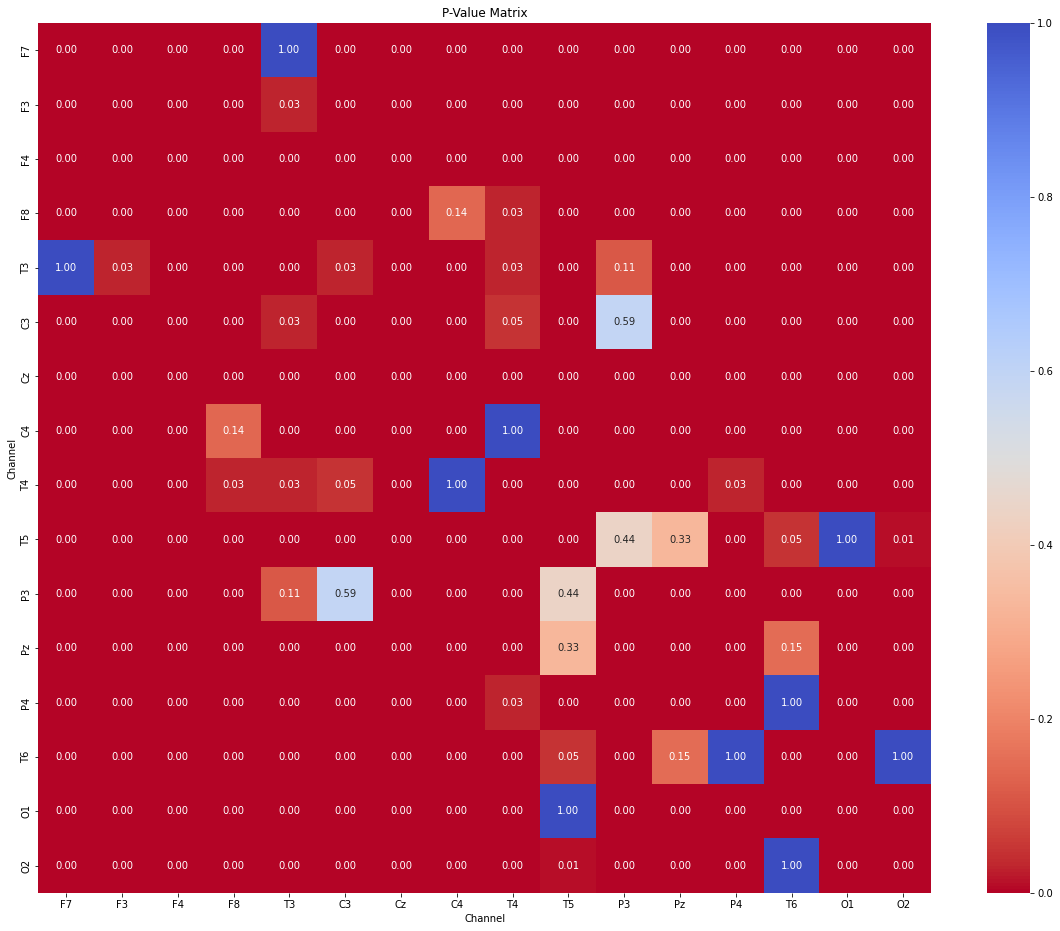

In [20]:
plot_p_value_matrix('power_alpha', 50, 100)

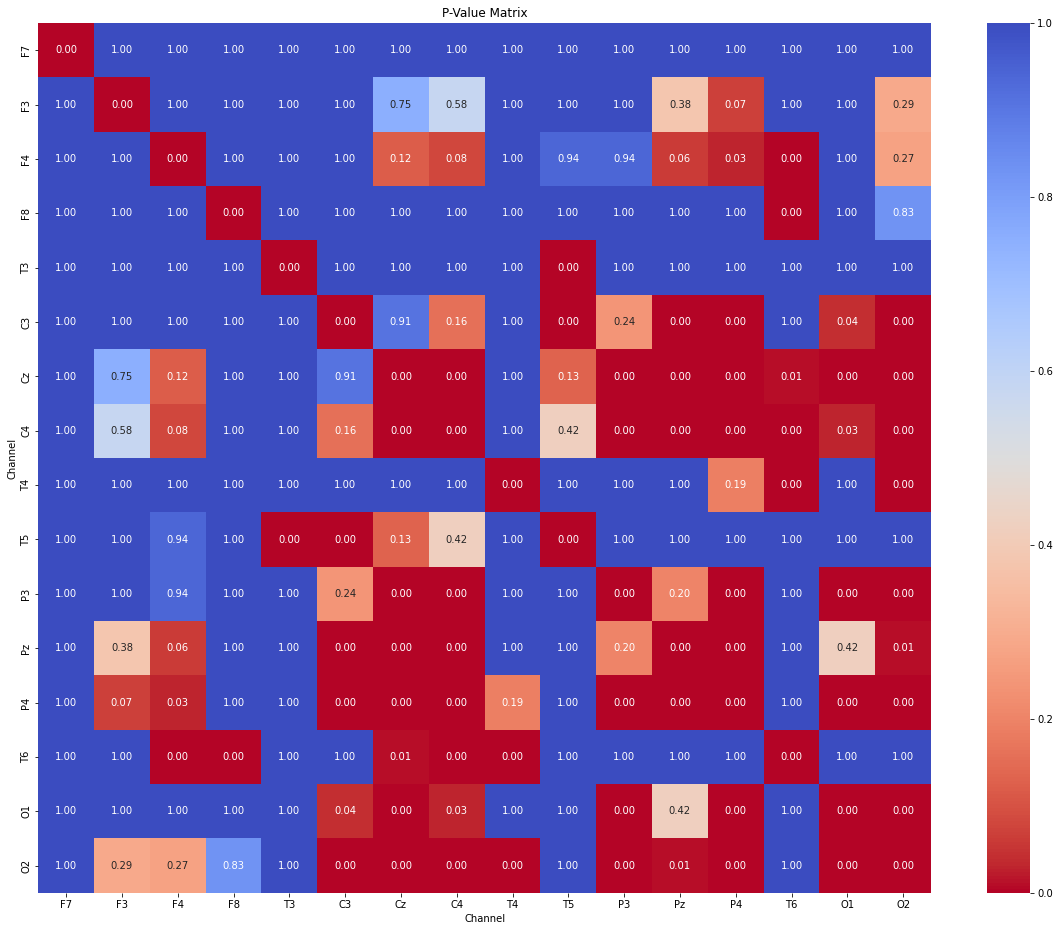

In [21]:
plot_p_value_matrix('power_theta', 50, 100)